# Training a CNN for a real-world Image Classification Task

This is an example of defining and training a CNN to deal with a real-world image classification. These are images taken by numerous amatuer photgraphers, in multiple cameras and lightening conditions. 

We will show:
1. How a relatively shallow CNN with 5 convolution layers and about 1 million parameters can defined in a dozen lines of code, and trained for 30m on a CPU (or ~3m on a GPU), to achieve reasnoble accuracy for classifying real-world images (74.3%). 
2. We will see, that getting to good results on relatively small training data (1000 samples per class in a binary classification task) can be greatly improved by introducing **data augmentation** and **dropout**. This will set the accuracy at 81.7%. This is just the beginning - training a larger network with more data could easily increase the accuracy. Fine-tunning a large CNN pre-trained on other images, and fine-tuned on the same small dataset - is an excellent way to increase the accuracy further. 
3. We will use the `dataset` API, that was introduced in a previous notebook. 

Here we are following Chollet Deep Learning with Python, chapter 8. The code was adapted for its Github notebook based on the Apache 2.0 license. 


In [10]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

Load the data into three sets: 

In [3]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

In [4]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Definning the model

In [5]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [7]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Note that running the training on a CPU could take about 30 minutes.

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 55s 863ms/step - loss: 0.6995 - accuracy: 0.5100 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 63s 1s/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.7935 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 62s 973ms/step - loss: 0.6786 - accuracy: 0.5715 - val_loss: 0.6726 - val_accuracy: 0.5280
Epoch 4/30
63/63 [==============================] - 64s 1s/step - loss: 0.6487 - accuracy: 0.6255 - val_loss: 0.6123 - val_accuracy: 0.6550
Epoch 5/30
63/63 [==============================] - 63s 996ms/step - loss: 0.6053 - accuracy: 0.6590 - val_loss: 0.6162 - val_accuracy: 0.6460
Epoch 6/30
63/63 [==============================] - 60s 957ms/step - loss: 0.5668 - accuracy: 0.7065 - val_loss: 0.6503 - val_accuracy: 0.6330
Epoch 7/30
63/63 [==============================] - 60s 951ms/step - loss: 0.5442 - accuracy: 0.7220 - val_loss: 0.6107 - val_accuracy: 0.6730
Epoch

**Displaying curves of loss and accuracy during training**

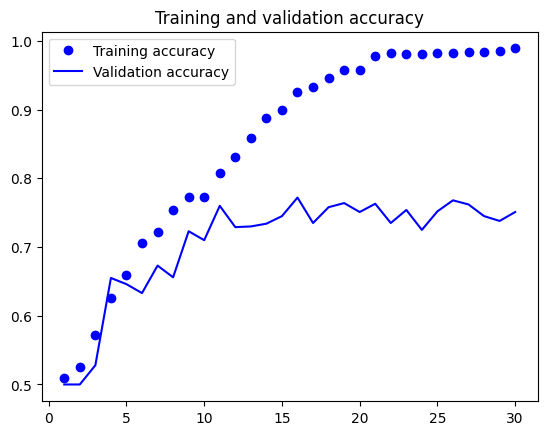

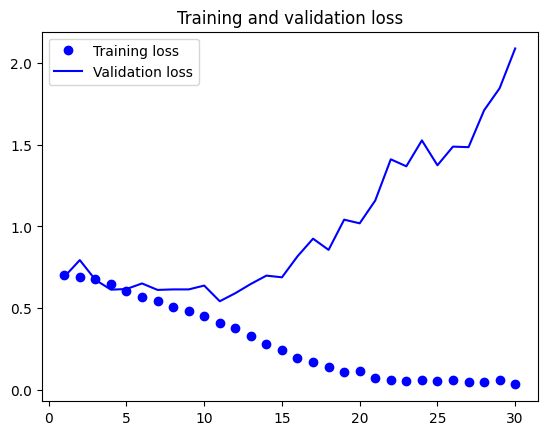

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Overfitting is evident, around epoch 12. 

**Evaluating the model on the test set**

In [12]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 13s 197ms/step - loss: 0.5745 - accuracy: 0.7430
Test accuracy: 0.743


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

See the Keras documentation to see what each method does. Notice that the augmentations are defined as a sequential model.

**Displaying some randomly augmented training images**

Here we use the `data_augmentation` model that we defined above, and pass the same image nine times.
Can you identify the three augmenting effects? 

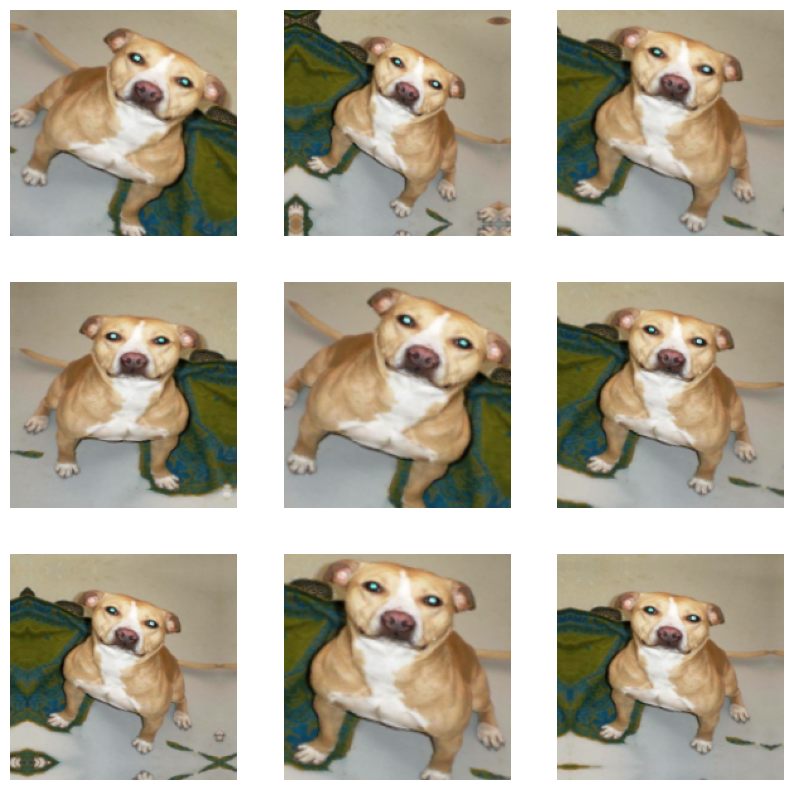

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

Our new model includes two changes compared to the previous one:
1. data augmentation as the first step
2. a dropout layer just before the last layer for regularization

In [15]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

Notice that the number of parameters is the same as the previous model.

**Training the regularized convnet**

Here we train for 100 epochs, compared to 30 before. Since the previous model overfitted after about 12 epoches, this discrepency still allows one to reasonably compare the performance of the two models. 

Note: running the training on a CPU will take about 2 hours.

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 64s 1s/step - loss: 0.6950 - accuracy: 0.4850 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 66s 1s/step - loss: 0.6915 - accuracy: 0.5310 - val_loss: 0.6779 - val_accuracy: 0.5840
Epoch 3/100
63/63 [==============================] - 65s 1s/step - loss: 0.6799 - accuracy: 0.5755 - val_loss: 0.6542 - val_accuracy: 0.6180
Epoch 4/100
63/63 [==============================] - 65s 1s/step - loss: 0.6606 - accuracy: 0.6235 - val_loss: 0.6354 - val_accuracy: 0.6590
Epoch 5/100
63/63 [==============================] - 64s 1s/step - loss: 0.6443 - accuracy: 0.6350 - val_loss: 0.6361 - val_accuracy: 0.6490
Epoch 6/100
63/63 [==============================] - 66s 1s/step - loss: 0.6285 - accuracy: 0.6555 - val_loss: 0.6558 - val_accuracy: 0.6290
Epoch 7/100
63/63 [==============================] - 64s 1s/step - loss: 0.6327 - accuracy: 0.6585 - val_loss: 0.6456 - val_accuracy: 0.6080
Epoch 8/100
6

**Evaluating the model on the test set**

Note the data augmentation and dropout are applied only during training, not during inference. 

In [17]:
test_model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 14s 220ms/step - loss: 0.4501 - accuracy: 0.8175
Test accuracy: 0.817


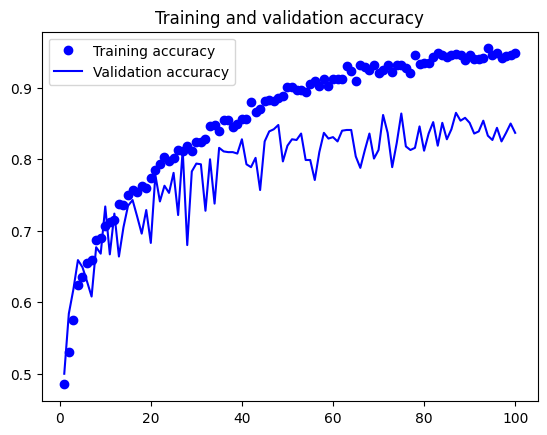

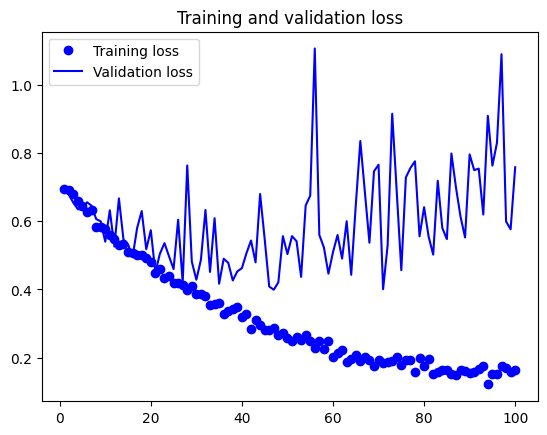

In [18]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Here an overfit is much less evident. Based on the validation accuracy it might have been reached only towards the last few epoches. Though the vaidation loss, while noisy, starts to increase after the 50th epoch or so. 